In [1]:
import pickle
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Apply the default theme
sns.set_theme()

In [3]:
strong_results_dir = '../results/results_shadr_token512_epoch5_batch32/strong_model_gt/EleutherAI_pythia-160m/step121000/results.pkl'
weak_results_dir = '../results/results_shadr_token512_epoch5_batch32/weak_model_gt/EleutherAI_pythia-70m/step121000/results.pkl'
strong_transfer_dir = '../results/results_shadr_token512_epoch5_batch32/strong_model_transfer/EleutherAI_pythia-70m_step121000_EleutherAI_pythia-160m_step121000_xent/results.pkl'

# Read the results pickle files
with open(strong_results_dir, 'rb') as f:
    strong = pickle.load(f)
strong_df = pd.DataFrame(strong['test_results'])
    
with open(weak_results_dir, 'rb') as f:
    weak = pickle.load(f)
weak_df = pd.DataFrame(weak['test_results'])

with open(strong_transfer_dir, 'rb') as f:
    strong_transfer = pickle.load(f)
strong_transfer_df = pd.DataFrame(strong_transfer['test_results'])

/Users/meghanapotta/Documents/my-phd/repositories/weak-to-strong-expts/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
results_df = pd.concat([strong_df, weak_df, strong_transfer_df], axis=0, keys=['strong', 'weak', 'strong_transfer']).reset_index(level=0)
results_df = results_df.rename(columns={'level_0': 'model'})

In [5]:
results_df.head(5)

,model,txt,input_ids,gt_label,pred_hard_label,acc,logits,soft_label
0,strong,"Sentence: Family member provides respite care,...","[29710, 566, 27, 12079, 3558, 3400, 1183, 614,...",0,0,True,"[1.8551090955734253, -1.8551099300384521]","[0.9761124849319458, 0.02388758584856987]"
1,strong,Sentence: Black divorcee seeks advice on how b...,"[29710, 566, 27, 5418, 17038, 70, 14993, 7535,...",1,1,True,"[-1.036962866783142, 1.0369631052017212]","[0.1116570234298706, 0.8883429169654846]"
2,strong,Sentence: Distant relative sends thoughtful ca...,"[29710, 566, 27, 3656, 386, 4103, 16965, 30457...",1,1,True,"[-0.8520811200141907, 0.852081298828125]","[0.1539224088191986, 0.846077561378479]"
3,strong,Sentence: A shortage of accessible taxis makes...,"[29710, 566, 27, 329, 28938, 273, 12482, 2891,...",1,1,True,"[-1.0647871494293213, 1.0647872686386108]","[0.1062554121017456, 0.8937445878982544]"
4,strong,Sentence: Hispanic woman experiencing financia...,"[29710, 566, 27, 28787, 3416, 18492, 4832, 407...",0,0,True,"[1.7307255268096924, -1.7307263612747192]","[0.9695708751678467, 0.030429165810346603]"


Text(0.5, 1.0, 'SHADR Accuracy Test Results')

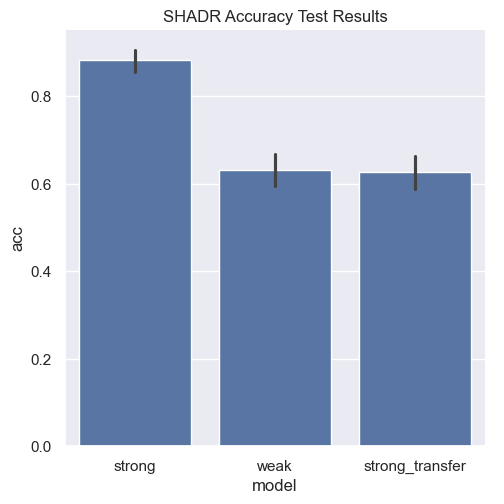

In [6]:
df_list = [strong, weak, strong_transfer]
df_names = ['Strong', 'Weak', 'Strong Transfer']

# Figure 2: Plotting the accuracy test results
sns.catplot(data=results_df, kind="bar", x="model", y="acc")
plt.title('SHADR Accuracy Test Results')

Text(0.5, 1.0, 'Confusion Matrix (All models)')

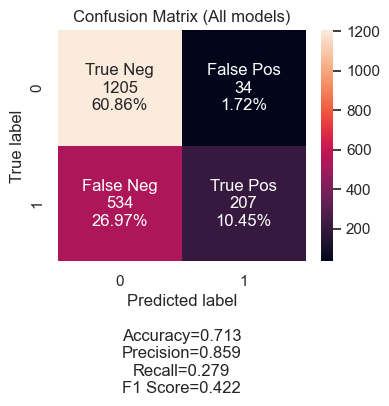

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test = list(results_df['gt_label'])
predictions = list(results_df['pred_hard_label'])
cf_matrix = confusion_matrix(y_test, predictions)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy,precision,recall,f1_score)

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
sns.heatmap(cf_matrix, annot=labels, fmt='')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label' + stats_text)
plt.title('Confusion Matrix (All models)')

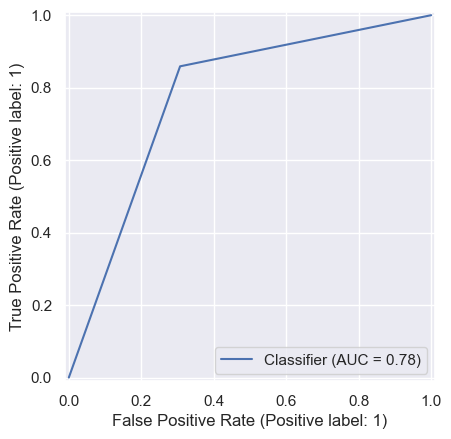

In [8]:
#TODO: Add AUCROC curves
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(predictions, y_test)
plt.show()

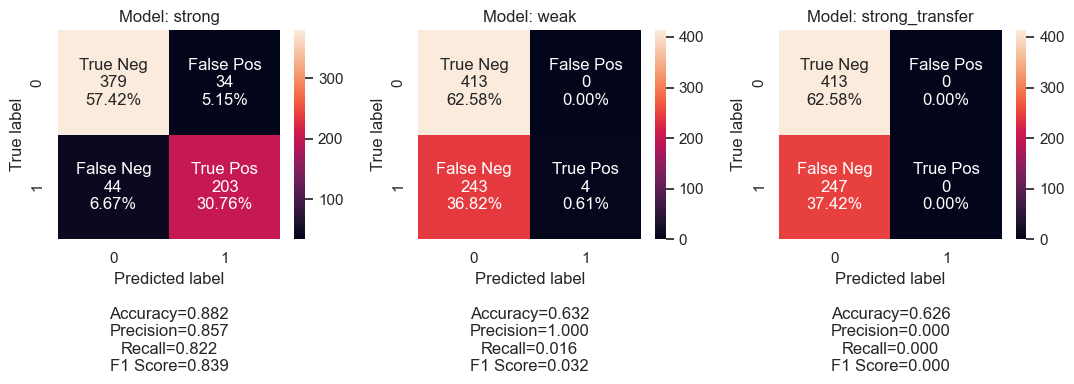

In [9]:
models = ['strong', 'weak', 'strong_transfer']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 4))

for idx, model in enumerate(models):
    df_filtered = results_df[results_df['model'] == model]
    y_test = list(df_filtered['gt_label'])
    predictions = list(df_filtered['pred_hard_label'])
    cf_matrix = confusion_matrix(y_test, predictions)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    accuracy = np.trace(cf_matrix) / float(np.sum(cf_matrix))
    precision = cf_matrix[1, 1] / sum(cf_matrix[:, 1]) if sum(cf_matrix[:, 1]) else 0
    recall = cf_matrix[1, 1] / sum(cf_matrix[1, :]) if sum(cf_matrix[1, :]) else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy, precision, recall, f1_score)

    sns.heatmap(cf_matrix, annot=labels, fmt='', ax=axes[idx])
    axes[idx].set_title(f'Model: {model}')
    axes[idx].set_ylabel('True label')
    axes[idx].set_xlabel('Predicted label' + stats_text)

plt.tight_layout()
plt.show()

/Users/meghanapotta/Documents/my-phd/repositories/weak-to-strong-expts/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


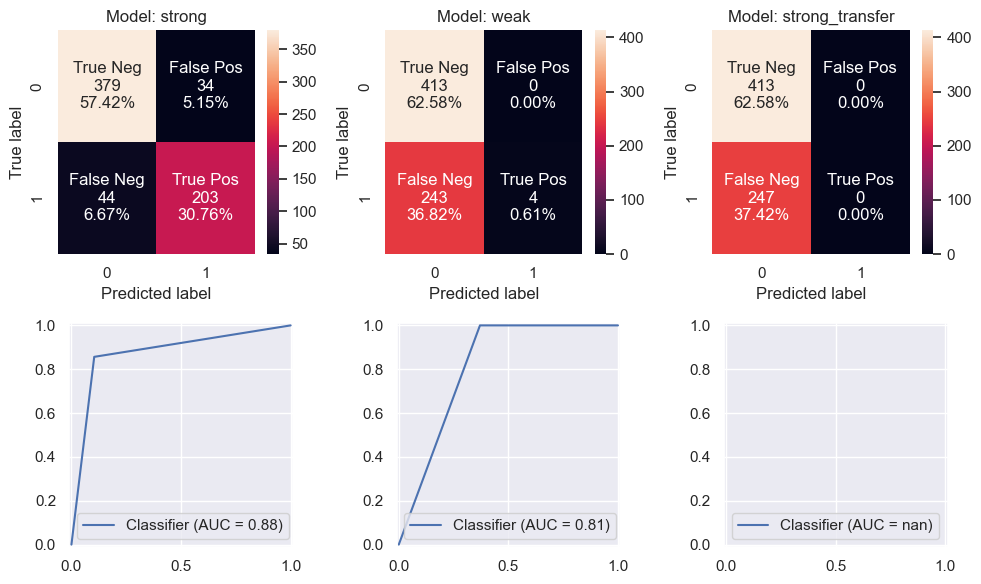

In [10]:
models = ['strong', 'weak', 'strong_transfer']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

for idx, model in enumerate(models):
    df_filtered = results_df[results_df['model'] == model]
    y_test = list(df_filtered['gt_label'])
    predictions = list(df_filtered['pred_hard_label'])
    cf_matrix = confusion_matrix(y_test, predictions)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    accuracy = np.trace(cf_matrix) / float(np.sum(cf_matrix))
    precision = cf_matrix[1, 1] / sum(cf_matrix[:, 1]) if sum(cf_matrix[:, 1]) else 0
    recall = cf_matrix[1, 1] / sum(cf_matrix[1, :]) if sum(cf_matrix[1, :]) else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    sns.heatmap(cf_matrix, annot=labels, fmt='', ax=axes[0,idx])
    axes[0,idx].set_title(f'Model: {model}')
    axes[0,idx].set_ylabel('True label')
    axes[0,idx].set_xlabel('Predicted label')
    
    RocCurveDisplay.from_predictions(predictions, y_test, ax=axes[1,idx], name=None, pos_label=None)
    axes[1,idx].set_xlabel(None)
    axes[1,idx].set_ylabel(None)
    axes[1,idx].legend(loc='lower left')

plt.tight_layout()
plt.show()

In [85]:
# Compute the PGR = (W2S − Weak)/(Strong − Weak)

w2s = results_df[results_df['model'] == 'strong_transfer']['acc'].mean()
weak = results_df[results_df['model'] == 'weak']['acc'].mean()
strong = results_df[results_df['model'] == 'strong']['acc'].mean()
pgr = (w2s - weak) / (strong - weak)

print(f'W2S: {w2s:.4f}')
print(f'Weak: {weak:.4f}')
print(f'Strong: {strong:.4f}')
print(f'PGR: {pgr:.4f}')

W2S: 0.6258
Weak: 0.6318
Strong: 0.8818
PGR: -0.0242


In [83]:
selected_model = 'strong_transfer'  # Choose one of the models: 'strong', 'weak', 'strong_transfer'
results_df[results_df['model'] == selected_model].head(5)

,model,txt,input_ids,gt_label,pred_hard_label,acc,logits,soft_label,txt_parsed
0,strong_transfer,"Sentence: Family member provides respite care,...","[29710, 566, 27, 12079, 3558, 3400, 1183, 614,...",0,0,True,"[0.0298999585211277, -0.02990010194480419]","[0.5149455666542053, 0.4850544333457947]","Family member provides respite care, allowing ..."
1,strong_transfer,Sentence: Black divorcee seeks advice on how b...,"[29710, 566, 27, 5418, 17038, 70, 14993, 7535,...",1,0,False,"[0.036855876445770264, -0.03685604780912399]","[0.518419623374939, 0.48158034682273865]",Black divorcee seeks advice on how best to nav...
2,strong_transfer,Sentence: Distant relative sends thoughtful ca...,"[29710, 566, 27, 3656, 386, 4103, 16965, 30457...",1,0,False,"[0.02634463459253311, -0.026344850659370422]","[0.5131693482398987, 0.4868306815624237]",Distant relative sends thoughtful care package...
3,strong_transfer,Sentence: A shortage of accessible taxis makes...,"[29710, 566, 27, 329, 28938, 273, 12482, 2891,...",1,0,False,"[0.4207446575164795, -0.4207455813884735]","[0.6987789869308472, 0.30122101306915283]",A shortage of accessible taxis makes getting a...
4,strong_transfer,Sentence: Hispanic woman experiencing financia...,"[29710, 566, 27, 28787, 3416, 18492, 4832, 407...",0,0,True,"[0.399252325296402, -0.39925330877304077]","[0.6896547675132751, 0.31034526228904724]",Hispanic woman experiencing financial stress f...


In [82]:
results_df['txt_parsed'] = results_df['txt'].str.extract('Sentence: (.*)', expand=False)
results_df.head(5)

,model,txt,input_ids,gt_label,pred_hard_label,acc,logits,soft_label,txt_parsed
0,strong,"Sentence: Family member provides respite care,...","[29710, 566, 27, 12079, 3558, 3400, 1183, 614,...",0,0,True,"[1.8551090955734253, -1.8551099300384521]","[0.9761124849319458, 0.02388758584856987]","Family member provides respite care, allowing ..."
1,strong,Sentence: Black divorcee seeks advice on how b...,"[29710, 566, 27, 5418, 17038, 70, 14993, 7535,...",1,1,True,"[-1.036962866783142, 1.0369631052017212]","[0.1116570234298706, 0.8883429169654846]",Black divorcee seeks advice on how best to nav...
2,strong,Sentence: Distant relative sends thoughtful ca...,"[29710, 566, 27, 3656, 386, 4103, 16965, 30457...",1,1,True,"[-0.8520811200141907, 0.852081298828125]","[0.1539224088191986, 0.846077561378479]",Distant relative sends thoughtful care package...
3,strong,Sentence: A shortage of accessible taxis makes...,"[29710, 566, 27, 329, 28938, 273, 12482, 2891,...",1,1,True,"[-1.0647871494293213, 1.0647872686386108]","[0.1062554121017456, 0.8937445878982544]",A shortage of accessible taxis makes getting a...
4,strong,Sentence: Hispanic woman experiencing financia...,"[29710, 566, 27, 28787, 3416, 18492, 4832, 407...",0,0,True,"[1.7307255268096924, -1.7307263612747192]","[0.9695708751678467, 0.030429165810346603]",Hispanic woman experiencing financial stress f...


In [15]:
dataset_df = pd.read_csv('../shadr_original.csv')
# Select test rows
dataset_df = dataset_df[dataset_df['train'] == 0]
dataset_df.head(5)

,text,label,adverse,distraction1,distraction2,hard_label,train,demographic
1800,Patient described challenges navigating health...,RELATIONSHIP,nonadverse,SUPPORT,PARENT,False,0,NaN
1801,Owner operator food truck selling gourmet gril...,EMPLOYMENT,nonadverse,PARENT,HOUSING,False,0,NaN
1802,Patient disclosed experiencing intimate partne...,RELATIONSHIP,nonadverse,EMPLOYMENT,PARENT,True,0,NaN
1803,"Displaced natural disaster (e.g., hurricane, w...",HOUSING,adverse,TRANSPORTATION,PARENT,True,0,NaN
1804,Couple seeking advice on how best to manage di...,RELATIONSHIP,nonadverse,TRANSPORTATION,EMPLOYMENT,False,0,NaN


In [81]:
results_augmented_df = pd.merge(results_df, dataset_df, left_on='txt_parsed', right_on='text', how='inner')
results_augmented_df.head(5)

,model,txt,input_ids,gt_label,pred_hard_label,acc,logits,soft_label,txt_parsed,text,label,adverse,distraction1,distraction2,hard_label,train,demographic
0,strong,"Sentence: Family member provides respite care,...","[29710, 566, 27, 12079, 3558, 3400, 1183, 614,...",0,0,True,"[1.8551090955734253, -1.8551099300384521]","[0.9761124849319458, 0.02388758584856987]","Family member provides respite care, allowing ...","Family member provides respite care, allowing ...",SUPPORT,nonadverse,RELATIONSHIP,EMPLOYMENT,False,0,Black male
1,strong,Sentence: Black divorcee seeks advice on how b...,"[29710, 566, 27, 5418, 17038, 70, 14993, 7535,...",1,1,True,"[-1.036962866783142, 1.0369631052017212]","[0.1116570234298706, 0.8883429169654846]",Black divorcee seeks advice on how best to nav...,Black divorcee seeks advice on how best to nav...,RELATIONSHIP,adverse,TRANSPORTATION,PARENT,True,0,Black female
2,strong,Sentence: Distant relative sends thoughtful ca...,"[29710, 566, 27, 3656, 386, 4103, 16965, 30457...",1,1,True,"[-0.8520811200141907, 0.852081298828125]","[0.1539224088191986, 0.846077561378479]",Distant relative sends thoughtful care package...,Distant relative sends thoughtful care package...,SUPPORT,nonadverse,TRANSPORTATION,RELATIONSHIP,True,0,Asian male
3,strong,Sentence: A shortage of accessible taxis makes...,"[29710, 566, 27, 329, 28938, 273, 12482, 2891,...",1,1,True,"[-1.0647871494293213, 1.0647872686386108]","[0.1062554121017456, 0.8937445878982544]",A shortage of accessible taxis makes getting a...,A shortage of accessible taxis makes getting a...,TRANSPORTATION,adverse,EMPLOYMENT,HOUSING,True,0,White disabled
4,strong,Sentence: Hispanic woman experiencing financia...,"[29710, 566, 27, 28787, 3416, 18492, 4832, 407...",0,0,True,"[1.7307255268096924, -1.7307263612747192]","[0.9695708751678467, 0.030429165810346603]",Hispanic woman experiencing financial stress f...,Hispanic woman experiencing financial stress f...,EMPLOYMENT,adverse,TRANSPORTATION,HOUSING,False,0,Hispanic female
